<a href="https://colab.research.google.com/github/yongtaoliu/DNDKL_DVAE_PVSK/blob/main/im2spec_v3_PVSK_IV_Zhao_Clemson_Jiawei_PSU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Im2Spec PVSK IV

This notebook demonstrates how to perform structure-spectroscopy relationship analysis using dual variational autoencoders (VAEs). We investigate a halide perovskite AFM I-V data acquired via automated atomic force microscopy (AFM).

Specifically, the notebook implements an im2spec framework in which image-to-image and spectrum-to-spectrum VAEs are trained jointly with an explicit objective to align their latent spaces. Latent space alignment is achieved using two complementary approaches:
(i) incorporating a cosine similarity term into the loss function, and
(ii) learning a linear transformation that maps between the two latent spaces during training.

Additionally, the image-to-image VAE incorporates rotational invariance and, optionally, translational invariance.

# Import

In [ ]:
from typing import Union, Tuple, List, Type, Optional

import math
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

In [ ]:
#@title convEncoderNet { form-width: "20%" }

from warnings import warn, filterwarnings
filterwarnings("ignore", module="torch.nn.functional")
tt = torch.tensor

########################### Convolutional neural nets #########################

class convEncoderNet(nn.Module):
    """
    Standard convolutional encoder
    """
    def __init__(self,
                 input_dim: Tuple[int],
                 input_channels: int = 1,
                 latent_dim: int = 2,
                 hidden_dim: List[Tuple[int]] = None,
                 batchnorm: bool = True,
                 activation: str = "lrelu",
                 pool: bool = True,
                 ) -> None:
        """
        Initializes encoder module
        """
        super(convEncoderNet, self).__init__()
        if hidden_dim is None:
            hidden_dim = [(32,), (64, 64), (96, 96)]
        output_dim = [dim // 2**len(hidden_dim) for dim in input_dim]
        output_channels = hidden_dim[-1][-1]
        self.latent_dim = latent_dim
        self.feature_extractor = FeatureExtractor(
            len(input_dim), input_channels, hidden_dim,
            batchnorm, activation, pool)
        self.features2latent = features_to_latent(
            [output_channels, *output_dim], 2*latent_dim)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor]:
        """
        Forward pass
        """
        x = self.feature_extractor(x)
        encoded = self.features2latent(x)
        mu, log_sig = encoded.split(self.latent_dim, 1)
        return mu, log_sig


class convDecoderNet(nn.Module):
    """
    Standard convolutional decoder
    """
    def __init__(self,
                 latent_dim: int,
                 output_dim: int,
                 output_channels: int = 1,
                 hidden_dim: List[Tuple[int]] = None,
                 batchnorm: bool = True,
                 activation: str = "lrelu",
                 sigmoid_out: bool = True,
                 upsampling_mode: str = "bilinear",
                 ) -> None:
        """
        Initializes decoder module
        """
        super(convDecoderNet, self).__init__()
        if hidden_dim is None:
            hidden_dim = [(96, 96), (64, 64), (32,)]
        input_dim = [dim // 2**len(hidden_dim) for dim in output_dim]
        self.latent2features = latent_to_features(
            latent_dim, [hidden_dim[0][0], *input_dim])
        self.upsampler = Upsampler(
            len(output_dim), hidden_dim[0][0], hidden_dim, output_channels,
            batchnorm, activation, upsampling_mode)
        self.activation_out = nn.Sigmoid() if sigmoid_out else lambda x: x

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass
        """
        x = self.latent2features(x)
        x = self.activation_out(self.upsampler(x))
        return x


class ConvBlock(nn.Module):
    """
    Creates a block of layers each consisting of convolution operation,
    (optional) nonlinear activation and (optional) batch normalization
    """
    def __init__(self,
                 ndim: int,
                 input_channels: int,
                 hidden_dim: Tuple[int],
                 kernel_size: Union[Tuple[int], int] = 3,
                 stride: Union[Tuple[int], int] = 1,
                 padding: Union[Tuple[int], int] = 1,
                 batchnorm: bool = False,
                 activation: str = "lrelu",
                 pool: bool = False,
                 ) -> None:
        """
        Initializes module parameters
        """
        super(ConvBlock, self).__init__()
        if not 0 < ndim < 4:
            raise AssertionError("ndim must be equal to 1, 2 or 3")
        activation = get_activation(activation)
        hidden_dim = (input_channels,) + hidden_dim
        block = []
        for in_channels, out_channels in zip(hidden_dim, hidden_dim[1:]):
            block.append(get_conv(ndim)(in_channels, out_channels,
                         kernel_size=kernel_size, stride=stride, padding=padding))
            if activation is not None:
                block.append(activation())
            if batchnorm:
                block.append(get_bnorm(ndim)(out_channels))
        if pool:
            block.append(get_maxpool(ndim)(2, 2))
        self.block = nn.Sequential(*block)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Defines a forward pass
        """
        output = self.block(x)
        return output


class UpsampleBlock(nn.Module):
    """
    Upsampling performed using bilinear or nearest-neigbor interpolation
    followed by 1-by-1 convolution, which an be used to reduce a number of
    feature channels
    """
    def __init__(self,
                 ndim: int,
                 input_channels: int,
                 output_channels: int,
                 scale_factor: int = 2,
                 mode: str = "bilinear") -> None:
        """
        Initializes module parameters
        """
        super(UpsampleBlock, self).__init__()
        warn_msg = ("'bilinear' mode is not supported for 1D and 3D;" +
                    " switching to 'nearest' mode")
        if mode not in ("bilinear", "nearest"):
            raise NotImplementedError(
                "Use 'bilinear' or 'nearest' for upsampling mode")
        if not 0 < ndim < 4:
            raise AssertionError("ndim must be equal to 1, 2 or 3")
        if mode == "bilinear" and ndim in (3, 1):
            warn(warn_msg, category=UserWarning)
            mode = "nearest"
        self.mode = mode
        self.scale_factor = scale_factor
        self.conv = get_conv(ndim)(
            input_channels, output_channels,
            kernel_size=1, stride=1, padding=0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Defines a forward pass
        """
        x = F.interpolate(
            x, scale_factor=self.scale_factor, mode=self.mode)
        return self.conv(x)


class FeatureExtractor(nn.Sequential):
    """
    Convolutional feature extractor
    """
    def __init__(self,
                 ndim: int,
                 input_channels: int = 1,
                 hidden_dim: List[Tuple[int]] = None,
                 batchnorm: bool = True,
                 activation: str = "lrelu",
                 pool: bool = True,
                 ) -> None:
        """
        Initializes feature extractor module
        """
        super(FeatureExtractor, self).__init__()
        if hidden_dim is None:
            hidden_dim = [[16,], (32, 32), (64, 64)]
        for i, hdim in enumerate(hidden_dim):
            in_filters = input_channels if i == 0 else hidden_dim[i-1][-1]
            block = ConvBlock(ndim, in_filters, hdim,
                              batchnorm=batchnorm, activation=activation,
                              pool=pool)
            self.add_module("c{}".format(i), block)


class Upsampler(nn.Sequential):
    """
    Convolutional upsampler
    """
    def __init__(self,
                 ndim: int,
                 input_channels: int,
                 hidden_dim: List[Tuple[int]] = None,
                 output_channels: int = 1,
                 batchnorm: bool = True,
                 activation: str = "lrelu",
                 upsampling_mode: str = "bilinear",
                 ) -> None:
        """
        Initializes upsampler module
        """
        super(Upsampler, self).__init__()
        if hidden_dim is None:
            hidden_dim = [(64, 64), (32, 32), (16,)]
        upsampling_mode = 'nearest' if ndim in (1, 3) else upsampling_mode
        for i, hdim in enumerate(hidden_dim):
            in_filters = input_channels if i == 0 else hidden_dim[i-1][-1]
            block = ConvBlock(ndim, in_filters, hdim,
                              batchnorm=batchnorm, activation=activation,
                              pool=False)
            self.add_module("conv_block_{}".format(i), block)
            up = UpsampleBlock(ndim, hdim[-1], hdim[-1], mode=upsampling_mode)
            self.add_module("up_{}".format(i), up)

        out = ConvBlock(ndim, hdim[-1], (1,), 1, 1, 0, activation=None)
        self.add_module("output_layer", out)


class features_to_latent(nn.Module):
    """
    Maps features (usually, from a convolutional net/layer) to latent space
    """
    def __init__(self, input_dim: Tuple[int], latent_dim: int = 2) -> None:
        super(features_to_latent, self).__init__()
        self.reshape_ = torch.prod(tt(input_dim))
        self.fc_latent = nn.Linear(self.reshape_, latent_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(-1, self.reshape_)
        return self.fc_latent(x)


class latent_to_features(nn.Module):
    """
    Maps latent vector to feature space
    """
    def __init__(self, latent_dim: int, out_dim: Tuple[int]) -> None:
        super(latent_to_features, self).__init__()
        self.reshape_ = out_dim
        self.fc = nn.Linear(latent_dim, torch.prod(tt(out_dim)).item())

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc(x)
        return x.view(-1, *self.reshape_)

def get_bnorm(dim: int) -> Type[nn.Module]:
    bn_dict = {1: nn.BatchNorm1d, 2: nn.BatchNorm2d, 3: nn.BatchNorm3d}
    return bn_dict[dim]


def get_conv(dim: int) -> Type[nn.Module]:
    conv_dict = {1: nn.Conv1d, 2: nn.Conv2d, 3: nn.Conv3d}
    return conv_dict[dim]


def get_maxpool(dim: int) -> Type[nn.Module]:
    conv_dict = {1: nn.MaxPool1d, 2: nn.MaxPool2d, 3: nn.MaxPool3d}
    return conv_dict[dim]



########################## Fully-connected neural nets #########################

class fcEncoderNet(nn.Module):
    """
    Standard fully-connected encoder NN for VAE.
    The encoder outputs mean and standard evidation of the encoded distribution.
    """
    def __init__(self,
                 in_dim: Tuple[int],
                 latent_dim: int = 2,
                 input_channels: int = 1,
                 hidden_dim: List[int] = None,
                 activation: str = 'tanh',
                 softplus_out: bool = False,
                 flat: bool = True
                 ) -> None:
        """
        Initializes module
        """
        super(fcEncoderNet, self).__init__()
        if len(in_dim) not in [1, 2]:
            raise ValueError("in_dim must be (h, w) or (l,)")
        if hidden_dim is None:
            hidden_dim = [256, 256]
        self.in_dim = torch.prod(tt(in_dim)).item() * input_channels

        self.fc_layers = make_fc_layers(
            self.in_dim, hidden_dim, activation)
        self.fc11 = nn.Linear(hidden_dim[-1], latent_dim)
        self.fc12 = nn.Linear(hidden_dim[-1], latent_dim)
        self.activation_out = nn.Softplus() if softplus_out else lambda x: x

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor]:
        """
        Forward pass
        """
        x = x.view(-1, self.in_dim)
        x = self.fc_layers(x)
        mu = self.fc11(x)
        sigma = self.activation_out(self.fc12(x))
        return mu, sigma


class fcDecoderNet(nn.Module):
    """
    Standard fully-connected decoder for VAE
    """
    def __init__(self,
                 latent_dim: int,
                 output_dim: Tuple[int],
                 output_channels: int = 1,
                 hidden_dim: List[int] = None,
                 activation: str = 'tanh',
                 sigmoid_out: bool = True,
                 ) -> None:
        """
        Initializes module
        """
        super(fcDecoderNet, self).__init__()
        if len(output_dim) not in [1, 2]:
            raise ValueError("in_dim must be (h, w) or (l,)")
        if hidden_dim is None:
            hidden_dim = [256, 256]
        self.reshape = (output_channels,) + (output_dim)
        hidden_out = torch.prod(tt(output_dim)).item() * output_channels

        self.fc_layers = make_fc_layers(
            latent_dim, hidden_dim, activation)
        self.out = nn.Linear(hidden_dim[-1], hidden_out)
        self.activation_out = nn.Sigmoid() if sigmoid_out else lambda x: x

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        """
        Forward pass
        """
        x = self.fc_layers(z)
        x = self.activation_out(self.out(x))
        return x.view(-1, *self.reshape)


class sDecoderNet(nn.Module):
    """
    Spatial generator (decoder) network with fully-connected layers
    """
    def __init__(self,
                 latent_dim: int,
                 output_dim: Tuple[int],
                 output_channels: int = 1,
                 hidden_dim: List[int] = None,
                 activation: str = 'tanh',
                 sigmoid_out: bool = True,
                 ) -> None:
        """
        Initializes module
        """
        super(sDecoderNet, self).__init__()
        if len(output_dim) not in [1, 2]:
            raise ValueError("in_dim must be (h, w) or (l,)")
        if hidden_dim is None:
            hidden_dim = [256, 256]
        self.reshape = (output_channels,) + (output_dim)
        coord_dim = 1 if len(output_dim) < 2 else 2

        self.coord_latent = coord_latent(
            latent_dim, hidden_dim[0], coord_dim)
        self.fc_layers = make_fc_layers(
            hidden_dim[0], hidden_dim, activation)
        self.out = nn.Linear(hidden_dim[-1], output_channels)
        self.activation_out = nn.Sigmoid() if sigmoid_out else lambda x: x

    def forward(self, x_coord: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        """
        Forward pass
        """
        x = self.coord_latent(x_coord, z)
        x = self.fc_layers(x)
        x = self.activation_out(self.out(x))
        return x.view(-1, *self.reshape)


class coord_latent(nn.Module):
    """
    The "spatial" part of the iVAE's decoder that allows for translational
    and rotational invariance (based on https://arxiv.org/abs/1909.11663)
    """
    def __init__(self,
                 latent_dim: int,
                 out_dim: int,
                 ndim: int = 2,
                 activation_out: bool = True) -> None:
        """
        Initializes module
        """
        super(coord_latent, self).__init__()
        self.fc_coord = nn.Linear(ndim, out_dim)
        self.fc_latent = nn.Linear(latent_dim, out_dim, bias=False)
        self.activation = nn.Tanh() if activation_out else None

    def forward(self,
                x_coord: torch.Tensor,
                z: Tuple[torch.Tensor]) -> torch.Tensor:
        batch_dim, n = x_coord.size()[:2]
        x_coord = x_coord.reshape(batch_dim * n, -1)
        h_x = self.fc_coord(x_coord)
        h_x = h_x.reshape(batch_dim, n, -1)
        h_z = self.fc_latent(z)

        h_z = h_z.view(-1, h_z.size(-1))
        h = h_x.add(h_z.unsqueeze(1))
        h = h.reshape(batch_dim * n, -1)
        if self.activation is not None:
            h = self.activation(h)
        return h


def make_fc_layers(in_dim: int,
                   hidden_dim: List[int] = 128,
                   activation: str = "tanh"
                   ) -> Type[nn.Module]:
    """
    Generates a module with stacked fully-connected (aka dense) layers
    """
    fc_layers = []
    hidden_dim = [in_dim] + hidden_dim
    for h_in, h_out in zip(hidden_dim, hidden_dim[1:]):
        fc_layers.extend(
            [nn.Linear(h_in, h_out),
             get_activation(activation)()]),
             #get_bnorm(1)(h_out)])
    fc_layers = nn.Sequential(*fc_layers)
    return fc_layers


########################### Other utility functions ##########################

def grid2xy(X1: torch.Tensor, X2: torch.Tensor) -> torch.Tensor:
    X = torch.cat((X1[None], X2[None]), 0)
    d0, d1 = X.shape[0], X.shape[1] * X.shape[2]
    X = X.reshape(d0, d1).T
    return X


def imcoordgrid(im_dim: Tuple[int]) -> torch.Tensor:
    xx = torch.linspace(-1, 1, im_dim[0])
    yy = torch.linspace(1, -1, im_dim[1])
    x0, x1 = torch.meshgrid(xx, yy)
    return grid2xy(x0, x1)


def generate_grid(data_dim: Tuple[int]) -> torch.Tensor:
    """Generates 1D or 2D grid of coordinates. Returns a torch tensor with two
    axes. If the input data_dim indicates only one dimensional data, then the
    output will be a 2d torch tensor artificially augmented along the last
    dimension, of shape [N, 1].
    Args:
        data_dim:
            Dimensions of the input data.
    Raises:
        NotImplementedError:
            If the dimension (length) of the provided data_dim is not equal to
            1 or 2.
    Returns:
        The grid (always 2d).
    """

    if len(data_dim) not in [1, 2]:
        raise NotImplementedError("Currently supports only 1D and 2D data")
    if len(data_dim) == 1:
        return torch.linspace(-1, 1, data_dim[0])[:, None]
    return imcoordgrid(data_dim)


def transform_coordinates(coord: torch.Tensor,
                          phi: Union[torch.Tensor, float] = 0,
                          coord_dx: Union[torch.Tensor, float] = 0,
                          scale: Union[torch.Tensor, float] = 1.,
                          ) -> torch.Tensor:
    """
    Rotation of 2D coordinates followed by scaling and translation.
    For 1D grid, there is only transaltion. Operates on batches.
    """
    if coord.shape[-1] == 1:
        return coord + coord_dx
    coord = rotate_coordinates(coord, phi)
    return coord + coord_dx


def rotate_coordinates(coord: torch.Tensor,
                       phi: torch.Tensor,
                       ) -> torch.Tensor:
    """
    Rotation of 2D coordinates. Operates on batches
    """
    rotmat_r1 = torch.stack([torch.cos(phi), torch.sin(phi)], 1)
    rotmat_r2 = torch.stack([-torch.sin(phi), torch.cos(phi)], 1)
    rotmat = torch.stack([rotmat_r1, rotmat_r2], axis=1)
    coord = torch.bmm(coord, rotmat)
    return coord

def get_activation(activation: int) -> Type[nn.Module]:
    if activation is None:
        return
    activations = {"lrelu": nn.LeakyReLU, "tanh": nn.Tanh,
                   "softplus": nn.Softplus, "relu": nn.ReLU,
                   "gelu": nn.GELU}
    return activations[activation]


def init_dataloader(*args: torch.Tensor,
                    random_sampler: bool = False,
                    shuffle: bool = True,
                    **kwargs: int
                    ) -> Type[torch.utils.data.DataLoader]:
    """
    Returns initialized PyTorch dataloader, which is used by pyroVED's trainers.
    The inputs are torch Tensor objects containing training data and (optionally)
    labels.

    Example:
    >>> # Load training data stored as numpy array
    >>> train_data = np.load("my_training_data.npy")
    >>> # Transform numpy array to toech Tensor object
    >>> train_data = torch.from_numpy(train_data).float()
    >>> # Initialize dataloader
    >>> train_loader = init_dataloader(train_data)
    """
    batch_size = kwargs.get("batch_size", 100)
    tensor_set = torch.utils.data.dataset.TensorDataset(*args)
    if random_sampler:
        sampler = torch.utils.data.RandomSampler(tensor_set)
        data_loader = torch.utils.data.DataLoader(
            dataset=tensor_set, batch_size=batch_size, sampler=sampler)
    else:
        data_loader = torch.utils.data.DataLoader(
            dataset=tensor_set, batch_size=batch_size, shuffle=shuffle)
    return data_loader


def generate_latent_grid(d: int, **kwargs) -> torch.Tensor:
    """
    Generates a grid of latent space coordinates
    """
    dist = torch.distributions
    if isinstance(d, int):
        d = [d, d]
    z_coord = kwargs.get("z_coord")
    if z_coord:
        z1, z2, z3, z4 = z_coord
        grid_x = torch.linspace(z2, z1, d[0])
        grid_y = torch.linspace(z3, z4, d[1])
    else:
        grid_x = dist.Normal(0, 1).icdf(torch.linspace(0.95, 0.05, d[0]))
        grid_y = dist.Normal(0, 1).icdf(torch.linspace(0.05, 0.95, d[1]))
    z = []
    for xi in grid_x:
        for yi in grid_y:
            z.append(tt([xi, yi]).float().unsqueeze(0))
    return torch.cat(z), (grid_x, grid_y)


def set_torch_seed(seed: int = 1) -> None:
    """Sets all torch manual seeds"""
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Download data

In [ ]:
!wget "https://www.dropbox.com/scl/fi/hbzbyg6l2ps6eam93yxie/IV_Novelty.npz?rlkey=h8blktadcs92y3out3y5c5oeb&dl=0" -O IV_Novelty.npz

--2026-02-22 13:57:18--  https://www.dropbox.com/scl/fi/hbzbyg6l2ps6eam93yxie/IV_Novelty.npz?rlkey=h8blktadcs92y3out3y5c5oeb&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.85.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.85.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4b680f05afdc2c300bbbde54dc.dl.dropboxusercontent.com/cd/0/inline/C7Yi6RxczfmghjXN9GpePasOVJQqd0OmnkCPZuRqn0SqcJVN-ahjabPuZPNh3MHs0yVMAGBvuvI6x-J1ncUiTT20mrmU3nyCmuRHcKsBvdpY8lwxa2cmAyPLQO01t9wFnlLVUZj6CAzjycKZvbGHwV77/file# [following]
--2026-02-22 13:57:18--  https://uc4b680f05afdc2c300bbbde54dc.dl.dropboxusercontent.com/cd/0/inline/C7Yi6RxczfmghjXN9GpePasOVJQqd0OmnkCPZuRqn0SqcJVN-ahjabPuZPNh3MHs0yVMAGBvuvI6x-J1ncUiTT20mrmU3nyCmuRHcKsBvdpY8lwxa2cmAyPLQO01t9wFnlLVUZj6CAzjycKZvbGHwV77/file
Resolving uc4b680f05afdc2c300bbbde54dc.dl.dropboxusercontent.com (uc4b680f05afdc2c300bbbde54dc.dl.dropboxusercontent.com)... 162.125.85

### Load data

In [ ]:
data = np.load("IV_Novelty.npz")
data.files

['iv_curves',
 'X_measured',
 'indices_measured',
 'img_novelty_scores',
 'spectra_novelty_scores',
 'last_filename']

In [ ]:
iv = data['iv_curves']
iv.shape

(210, 251)

In [ ]:
# Calculate the number of points for the ascending and descending parts
# Total length is 251, so 126 points for ascending (0 to 1.5V) and 125 for descending (1.5V to 0V, excluding the peak)
ascending_points = 126
descending_points = 125
# Generate the ascending part of the voltage array
voltage_up = np.linspace(0, 1.5, ascending_points)
# Generate the descending part of the voltage array, excluding the starting point (1.5V) to avoid duplication
voltage_down = np.linspace(1.5, 0, descending_points + 1)[1:]

# Concatenate the two parts to form the final voltage array
vdc = np.concatenate((voltage_up, voltage_down))

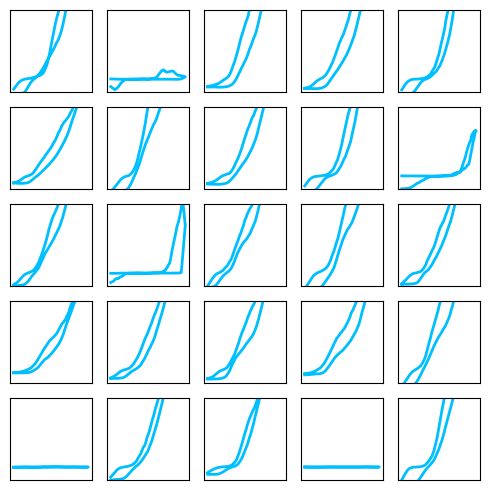

In [ ]:
# Number of patches to display
num_to_display = 36

np.random.seed(1)
random_indices = np.random.choice(210, num_to_display, replace=False)
fig, axes = plt.subplots(5, 5, figsize=(5, 5), dpi =100)  # Adjust grid size (4x5) as needed

# Flatten the axes array for easy indexing
axes_flat = axes.flatten()

for i, ax in enumerate(axes_flat):
    # Check if we have fewer data than slots; if so, turn off axis for empty slots
    if i >= num_to_display:
        ax.axis('off')
        continue

    ax.plot(vdc, iv[random_indices[i]]*1e9, c = 'deepskyblue', linewidth =2)
    # ax.axis('off')
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_ylim(-0.1, 0.5)
plt.tight_layout()
plt.show()

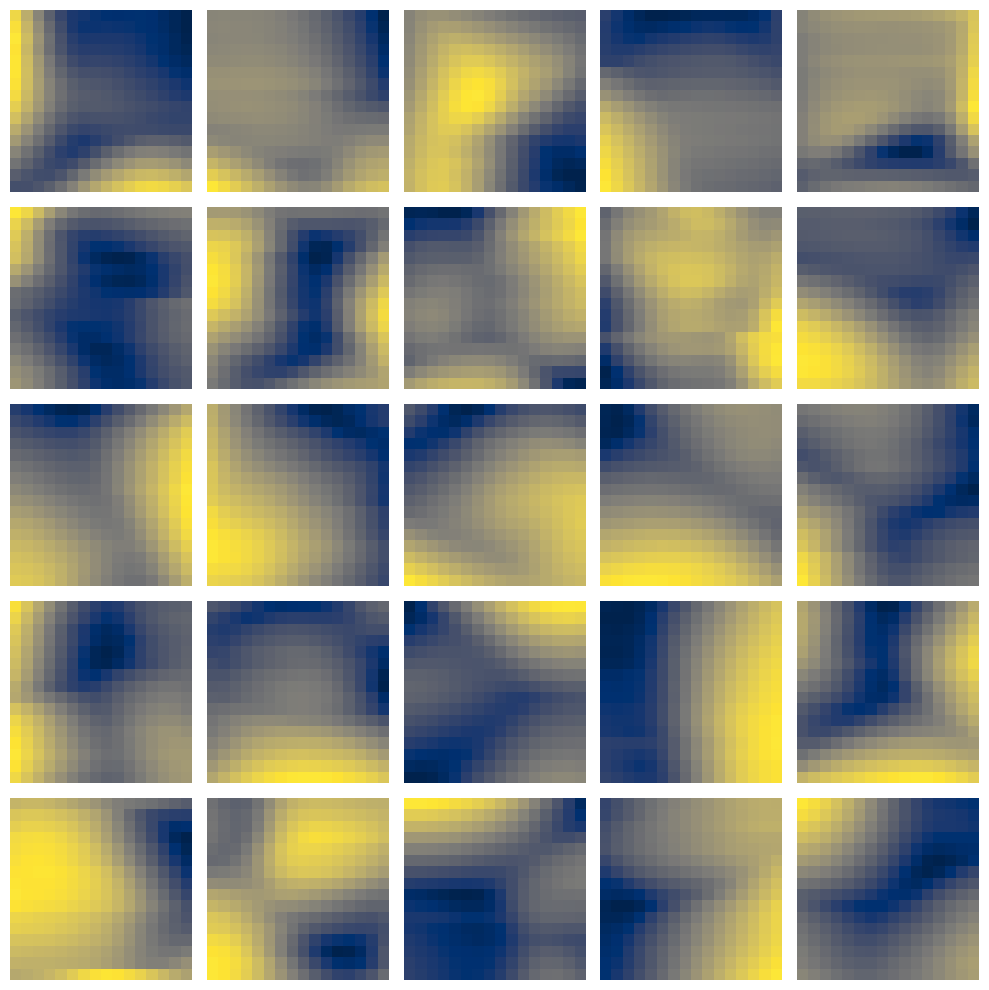

In [ ]:
topo = data['X_measured']
topo = topo.reshape((210, 16, 16))

# Number of patches to display
num_to_display = 36

np.random.seed(1)
random_indices = np.random.choice(210, num_to_display, replace=False)
fig, axes = plt.subplots(5, 5, figsize=(10, 10))  # Adjust grid size (4x5) as needed

# Flatten the axes array for easy indexing
axes_flat = axes.flatten()

for i, ax in enumerate(axes_flat):
    # Check if we have fewer patches than slots; if so, turn off axis for empty slots
    if i >= num_to_display:
        ax.axis('off')
        continue

    ax.imshow(topo[random_indices[i]], cmap = "cividis")
    ax.axis('off')
plt.tight_layout()
plt.show()

# Im2Spec Analysis

In [ ]:
# Normalize all structure
norm_ = lambda x: (x - x.min()) / (x.max() - x.min())
img = topo.copy()
for i in range (img.shape[0]):
  img[i,] = norm_(topo[i,])
# img = norm_(img)
iv = norm_(iv)

## Prepare torch data for training

In [ ]:
imgdata = img
specdata = iv

imgdata = torch.from_numpy(imgdata).float()
specdata = torch.from_numpy(specdata).float()

#specdata = F.avg_pool1d(specdata[:, None], 8, 8).squeeze()  # reduce the spectral size via average pooling

print(imgdata.shape, specdata.shape)

torch.Size([210, 16, 16]) torch.Size([210, 251])


## Train two VAEs with enforcing similarity b/w latent spaces


Initialize dataloader:

In [ ]:
imgdata = norm_(imgdata)
specdata = norm_(specdata)

train_loader = init_dataloader(imgdata.unsqueeze(1), specdata.unsqueeze(1), batch_size=200)  # unsqueeze(1) adds a channel dimension of 1

Initialize our model and an optimizer:

Finaly, we train the model. It is usually convenient to define a function that performs a single training step and then call it from within the training loop.

Encode data into the latent space(s) using the trained model:

## Train two VAEs with enforced similarity b/w latent spaces

Now, let's define an ```imspec``` class that learns a linear mapping (in a form of coefficients of a linear equation) between two latent spaces durign the training. The pass forward then consists of the following steps:
1. Pass $x_1$ through *encoder-1*. Get latent representation $z_1$. Compute KLD. Pass $z_1$ through *decoder-1*. Compute reconstruction loss.
2. Pass $x_2$ through *encoder-2*. Get latent representation $z_2$. Compute KLD (the latter is invariant under affine trasformation).
3. Get the $z_2' = Az_2$ transformation. Compute the $L_1(z_1, z_2')$ score.
4. Pass $z_2'$ through *decoder-2* and compute a reconstruction loss.

In [ ]:
#@title imspec3

class imspec(nn.Module):
    """
  We first define the ImSpec base class. It consists of a 'constructor' ```__init__```
  where we define our model parameters, methods for obtaining pdf-s (e.g., ```_log_normal```),
  computing different loss metrics (e.g. ```_compute_kld```), performing a reparametrization
  trick (```_reparameterize```), etc. These methods are going to be reused in all subsequent
  ImSpec models. Finally, there is a ```forward``` method, which defines a forward propagation
  of input data through our model. Here, the images will be passed through one VAE and the
  spectra are going to be passed through another VAE. The first VAE also enforces rotational
  and (optionally) translational invariance of the latent representation. At the moment, the
  two paths are not interacting. Note that our ```forward``` method also records all the
  computed losses.
    """

    def __init__(self,
                 indim1: Tuple[int, int], # assumed to be images
                 indim2: Tuple[int], # assumed to be spectra
                 latent_dim: int = 2,  # for now, both VAEs will have the same number of latent dims
                 coord: int = 0, # 1 for rotation, 2 for translations, 3 for rotation+translations
                 **kwargs: torch.Tensor) -> None:
        """Initialize model parameters"""
        super(imspec, self).__init__()
        device = "cuda" if torch.cuda.is_available() else 'cpu'
        # encoder and decoder for first dataset (e.g. structural images)
        self.encoder1 = fcEncoderNet(indim1, latent_dim + coord)
        dnet = sDecoderNet if coord > 0 else fcDecoderNet
        self.decoder1 = dnet(latent_dim, indim1)
        # encoder and decoder for second dataset (e.g. spectra)
        self.encoder2 = fcEncoderNet(indim2, latent_dim)
        self.decoder2 = fcDecoderNet(latent_dim, indim2)
        # Initialize grid and get 'prior' parameters for coordinate transformations
        self.grid = generate_grid(indim1).to(device)
        self.coord = coord
        self.phi_prior = kwargs.get("phi_prior", tt(math.pi / 2)).to(device)
        self.dt_prior = kwargs.get("dt_prior", tt(0.5)).to(device)
        # Place all model parameters on the appropriate device
        self.to(device)
        self.device = device

    def _compute_kld(self,
                     z: torch.Tensor,
                     q_param: Tuple[torch.Tensor],
                     p_param: Optional[Tuple[torch.Tensor]] = None
                     ) -> torch.Tensor:
        """
        Computes KL divergence term between two normal distributions
        or (if p_param = None) between normal and standard normal distributions
        """
        qz = self._log_normal(z, *q_param)
        if p_param is None:
            pz = self._log_unit_normal(z)
        else:
            pz = self._log_normal(z, *p_param)
        return qz - pz

    @classmethod
    def _reparameterize(cls,
                        z_mu: torch.Tensor,
                        z_logsig: torch.Tensor
                        ) -> torch.Tensor:
        """Reparametrization trick"""
        batch_dim = z_mu.size(0)
        z_dim = z_mu.size(1)
        z_sig = torch.exp(z_logsig)
        eps = z_mu.new(batch_dim, z_dim).normal_()
        return z_mu + z_sig * eps

    @classmethod
    def _log_normal(cls,
                   x: torch.Tensor,
                   mu: torch.Tensor,
                   log_sig: torch.Tensor
                   ) -> torch.Tensor:
        """
        Computes log-pdf of a normal distribution
        """
        log_pdf = (-0.5 * math.log(2 * math.pi) - log_sig -
                   (x - mu)**2 / (2 * torch.exp(log_sig)**2))
        return torch.sum(log_pdf, dim=-1)

    @classmethod
    def _log_unit_normal(cls, x: torch.Tensor) -> torch.Tensor:
        """
        Computes log-pdf of a unit normal distribution
        """
        log_pdf = -0.5 * (math.log(2 * math.pi) + x ** 2)
        return torch.sum(log_pdf, dim=-1)

    @classmethod
    def _compute_re(cls,
                    x: torch.Tensor,
                    x_reconstr: torch.Tensor) -> torch.Tensor:
        """Computes binary cross-entropy reconstruction loss"""
        reconstr_loss = F.binary_cross_entropy(
            x_reconstr.flatten(1), x.flatten(1), reduction='none').sum(-1)
        return reconstr_loss

    def _transform_coordinates(self,
                               grid: torch.Tensor,
                               t_vec: torch.Tensor) -> torch.Tensor:
        """Rotation and translation of the 2d coordinate grid"""
        phi = t_vec[:, 0]
        dt = t_vec[:, 1:].unsqueeze(1) if self.coord > 1 else 0
        grid = rotate_coordinates(grid, phi)
        return grid + self.dt_prior * dt

    def forward(self, x1: torch.Tensor, x2: torch.Tensor=None) -> torch.Tensor:
        """Forward Pass"""

        self.likelihood = 0
        self.kl_divergence = 0

        # First VAE
        # Encode data
        z_mu1, z_logsig1 = self.encoder1(x1)
        # Obtain latent vector throught he 'reparametrization trick'
        z_vec1 = self._reparameterize(z_mu1, z_logsig1)
        # Split latent vector into parts associated with coordinate transformations and data content
        t_vec1 = z_vec1[:, :self.coord]
        z_vec1 = z_vec1[:, self.coord:]
        # Compute KLD for the 'conventional' latent vector
        self.kl_divergence += self._compute_kld(
            z_vec1, (z_mu1[:, self.coord:], z_logsig1[:, self.coord:]))
        # Compute KLD for the latent angle (if any)
        if self.coord in [1, 3]:
            p_loc = t_vec1.new_zeros(t_vec1.size(0), 1)
            p_scale = t_vec1.new_ones(t_vec1.size(0), 1) * self.phi_prior
            self.kl_divergence += self._compute_kld(
                t_vec1[:, :1], (z_mu1[:, :1], z_logsig1[:, :1]), (p_loc, p_scale))
            z_mu1, z_logsig1 = z_mu1[:, 1:], z_logsig1[:, 1:]
            t_vec1 = t_vec1[:, 1:] if t_vec1.size(-1) > 1 else t_vec1
        # Compute KLD for the latent shift (if any)
        if self.coord in [2, 3]:
            self.kl_divergence += self._compute_kld(
                t_vec1, (z_mu1[:, :2], z_logsig1[:, :2])) # assume unit normal prior
        # Do the affine transformation for the coordinate grid (if any)
        decoder_input = (z_vec1,)
        if self.coord:
            grid = self.grid.expand(t_vec1.shape[0], *self.grid.shape)
            grid = self._transform_coordinates(grid, t_vec1)
            decoder_input = (grid,) + decoder_input
        # Pass latent data and transformed grid (if any) to decoder
        x_reconstr1 = self.decoder1(*decoder_input)
        # Compute reconstruction loss
        self.likelihood += -self._compute_re(x1, x_reconstr1)

        # Second VAE (just vanilla VAE)
        z_mu2, z_logsig2 = self.encoder2(x2)
        z_vec2 = self._reparameterize(z_mu2, z_logsig2)
        self.kl_divergence += self._compute_kld(z_vec2, (z_mu2, z_logsig2))
        x_reconstr2 = self.decoder2(z_vec2)
        self.likelihood += -self._compute_re(x2, x_reconstr2)

        return (z_vec1, x_reconstr1), (z_vec2, x_reconstr2)

class imspec3(imspec):

    def __init__(self,
                 indim1: Tuple[int, int], # assumed to be images
                 indim2: Tuple[int], # assumed to be spectra
                 latent_dim: int = 2,  # for now, both VAEs will have the same number of latent dims
                 coord: int = 0,
                 **kwargs: torch.Tensor) -> None:
        # Initilize encoders and decoders
        args = (indim1, indim2, latent_dim, coord)
        super(imspec3, self).__init__(*args, **kwargs)
        # Define the (learnable) linear transformation coefficients
        A = torch.zeros(latent_dim, latent_dim).fill_diagonal_(1)
        A = A.to(self.device)
        self.A = nn.Parameter(A)

    @classmethod
    def _compute_l1(cls,
                    x1: torch.Tensor,
                    x2: torch.Tensor) -> torch.Tensor:
        """Computes L1 score"""
        return (x1 -x2).abs().mean()

    def linear_transform(self, z: torch.Tensor):
        """Performs a linear transformation of the latent encoding"""
        return z @ self.A

    def forward(self, x1: torch.Tensor, x2: torch.Tensor) -> torch.Tensor:
        """Forward Pass"""

        self.likelihood = 0
        self.kl_divergence = 0

        # First VAE
        # Encode data
        z_mu1, z_logsig1 = self.encoder1(x1)
        # Obtain latent vector throught he 'reparametrization trick'
        z_vec1 = self._reparameterize(z_mu1, z_logsig1)
        # Split latent vector into parts associated with coordinate transformations and data content
        t_vec1 = z_vec1[:, :self.coord]
        z_vec1 = z_vec1[:, self.coord:]
        # Compute KLD for the 'conventional' latent vector
        self.kl_divergence += self._compute_kld(
            z_vec1, (z_mu1[:, self.coord:], z_logsig1[:, self.coord:]))
        # Compute KLD for the latent angle (if any)
        if self.coord in [1, 3]:
            p_loc = t_vec1.new_zeros(t_vec1.size(0), 1)
            p_scale = t_vec1.new_ones(t_vec1.size(0), 1) * self.phi_prior
            self.kl_divergence += self._compute_kld(
                t_vec1[:, :1], (z_mu1[:, :1], z_logsig1[:, :1]), (p_loc, p_scale))
            z_mu1, z_logsig1 = z_mu1[:, 1:], z_logsig1[:, 1:]
            t_vec1 = t_vec1[:, 1:] if t_vec1.size(-1) > 1 else t_vec1
        # Compute KLD for the latent shift (if any)
        if self.coord in [2, 3]:
            self.kl_divergence += self._compute_kld(
                t_vec1, (z_mu1[:, :2], z_logsig1[:, :2])) # assume unit normal prior
        # Do the affine transformation for the coordinate grid (if any)
        decoder_input = (z_vec1,)
        if self.coord:
            grid = self.grid.expand(t_vec1.shape[0], *self.grid.shape)
            grid = self._transform_coordinates(grid, t_vec1)
            decoder_input = (grid,) + decoder_input
        # Pass latent data and transformed grid (if any) to decoder
        x_reconstr1 = self.decoder1(*decoder_input)
        # Compute reconstruction loss
        self.likelihood += -self._compute_re(x1, x_reconstr1)

        # Second VAE
        z_mu2, z_logsig2 = self.encoder2(x2)
        z_mu2 = self.linear_transform(z_mu2) # Do linear transformation

        z_vec2 = self._reparameterize(z_mu2, z_logsig2)
        self.kl_divergence +=  self._compute_kld(z_vec2, (z_mu2, z_logsig2))

        self.simloss = self._compute_l1(z_vec1, z_vec2)  # Compute L1 score between two latent spaces

        x_reconstr2 = self.decoder2(z_vec2)
        self.likelihood += -self._compute_re(x2, x_reconstr2)

        return (z_vec1, x_reconstr1), (z_vec2, x_reconstr2)

Initialize, model, optimizer, and dataloader:

In [ ]:
epochs = 1000

In [ ]:
img_dim = (imgdata.shape[-1], imgdata.shape[-1])
spec_dim = (specdata.shape[-1],)

# (re-)initialize dat loader
train_loader = init_dataloader(imgdata.unsqueeze(1), specdata.unsqueeze(1), batch_size=2000)

# initialize model and optimizer
set_torch_seed(1)
model = imspec3(img_dim, spec_dim, latent_dim=2, coord=3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.12/dist-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4381.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Next we train dual VAE model. Here is that we add a ```simloss``` term to the loss function. We also add a ```gamma``` coefficients before this new loss term which controls it's relative contribution to the total loss.

In [ ]:
def train_step(x1: torch.Tensor, x2: torch.Tensor,
               beta: float = 1., gamma: float = 10.) -> float:
    model.train()
    _ = model(x1.to(model.device), x2.to(model.device))
    loss = -(model.likelihood - beta * model.kl_divergence).mean() + gamma * model.simloss
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item(), model.simloss.item()

train_loss, sim = [], []
for e in range(epochs):
    train_loss_i, sim_i = 0, 0
    for (x1, x2) in train_loader:
        loss_i, sscore_i = train_step(x1, x2)
        train_loss_i += loss_i
        sim_i += sscore_i
    train_loss.append(train_loss_i / len(train_loader))
    sim.append(sim_i / len(train_loader))
    print("Epoch {},  Train loss {}".format(e+1, train_loss[-1]))

Epoch 1,  Train loss 364.9847412109375
Epoch 2,  Train loss 362.56951904296875
Epoch 3,  Train loss 361.840087890625
Epoch 4,  Train loss 361.9501953125
Epoch 5,  Train loss 360.44476318359375
Epoch 6,  Train loss 359.6675109863281
Epoch 7,  Train loss 358.755615234375
Epoch 8,  Train loss 358.0254821777344
Epoch 9,  Train loss 357.2967224121094
Epoch 10,  Train loss 356.29534912109375
Epoch 11,  Train loss 355.5701599121094
Epoch 12,  Train loss 354.89849853515625
Epoch 13,  Train loss 353.7364807128906
Epoch 14,  Train loss 353.1475524902344
Epoch 15,  Train loss 352.3507385253906
Epoch 16,  Train loss 351.63385009765625
Epoch 17,  Train loss 350.9788818359375
Epoch 18,  Train loss 350.3040466308594
Epoch 19,  Train loss 349.35040283203125
Epoch 20,  Train loss 348.69677734375
Epoch 21,  Train loss 347.6914978027344
Epoch 22,  Train loss 346.9823913574219
Epoch 23,  Train loss 346.16778564453125
Epoch 24,  Train loss 345.50323486328125
Epoch 25,  Train loss 344.885986328125
Epoch 26,

Encode data into the latent spaces. Note that we have an extra line that applies a learned transformation to the encoded $z$.

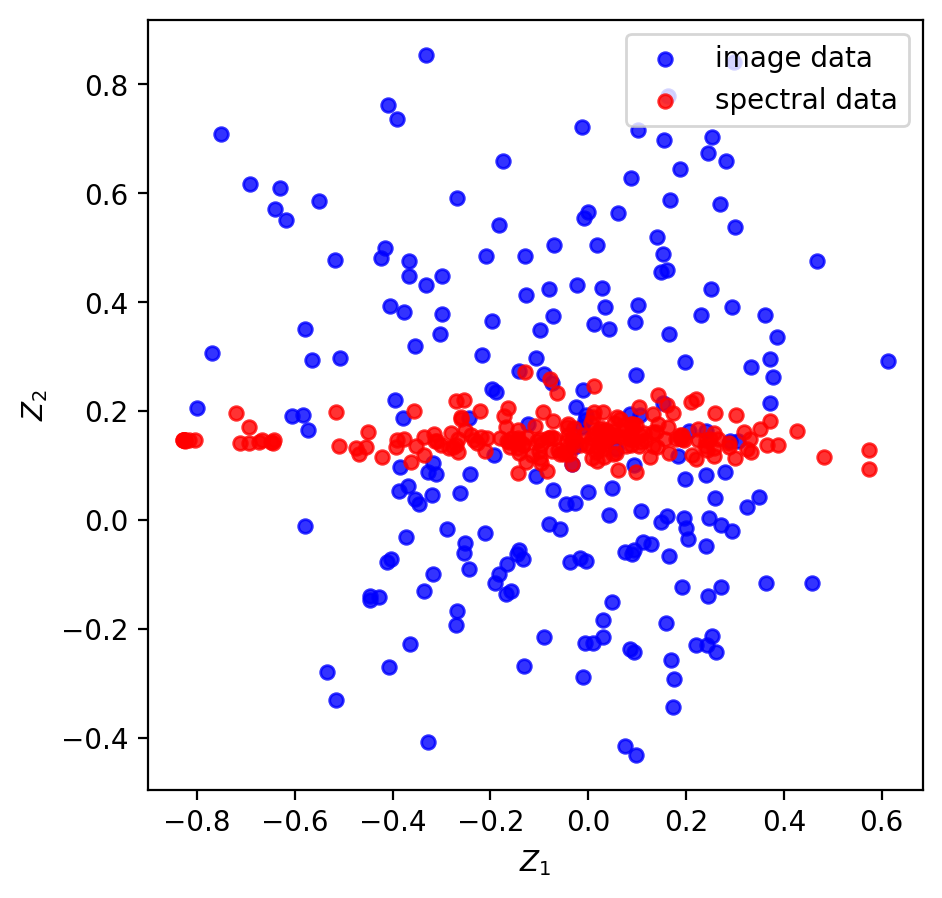

In [ ]:
test_loader = init_dataloader(imgdata.unsqueeze(1), specdata.unsqueeze(1), shuffle=False)

model.eval()
with torch.no_grad():
    z_mu1 = torch.cat([model.encoder1(x.to(model.device))[0].cpu() for (x,_) in test_loader])
    z_mu2 = torch.cat([model.encoder2(x.to(model.device))[0].cpu() for (_,x) in test_loader])
    z_mu2 = z_mu2.matmul(model.A.cpu())  # a.matmul(b) is equivalent to a @ b and to torch.matmul(a, b)

plt.figure (figsize = (5,5), dpi = 200)
plt.scatter(z_mu1[:, -1], z_mu1[:, -2], s=24, alpha=0.8, marker = "o", label="image data", c = 'blue')
plt.scatter(z_mu2[:, -1], z_mu2[:, -2], s=24, alpha=0.8, marker = "o",label="spectral data", c = 'r')
plt.xlabel ('$Z$$_1$')
plt.ylabel ('$Z$$_2$')
plt.legend()


View the learned latent manifolds. Note that we have an extra line that applies a learned transformation to the $z$ vector.

In [ ]:
d =10
z, (gridx, gridy) = generate_latent_grid(d)
z_t = torch.matmul(z, model.A.cpu())
coord_grid = model.grid.expand(len(z), *model.grid.shape)

with torch.no_grad():
    manifold1 = model.decoder1(coord_grid, z.to(model.device)).cpu()
    manifold2 = model.decoder2(z_t.to(model.device)).cpu()

(np.float64(-0.5), np.float64(170.5), np.float64(170.5), np.float64(-0.5))

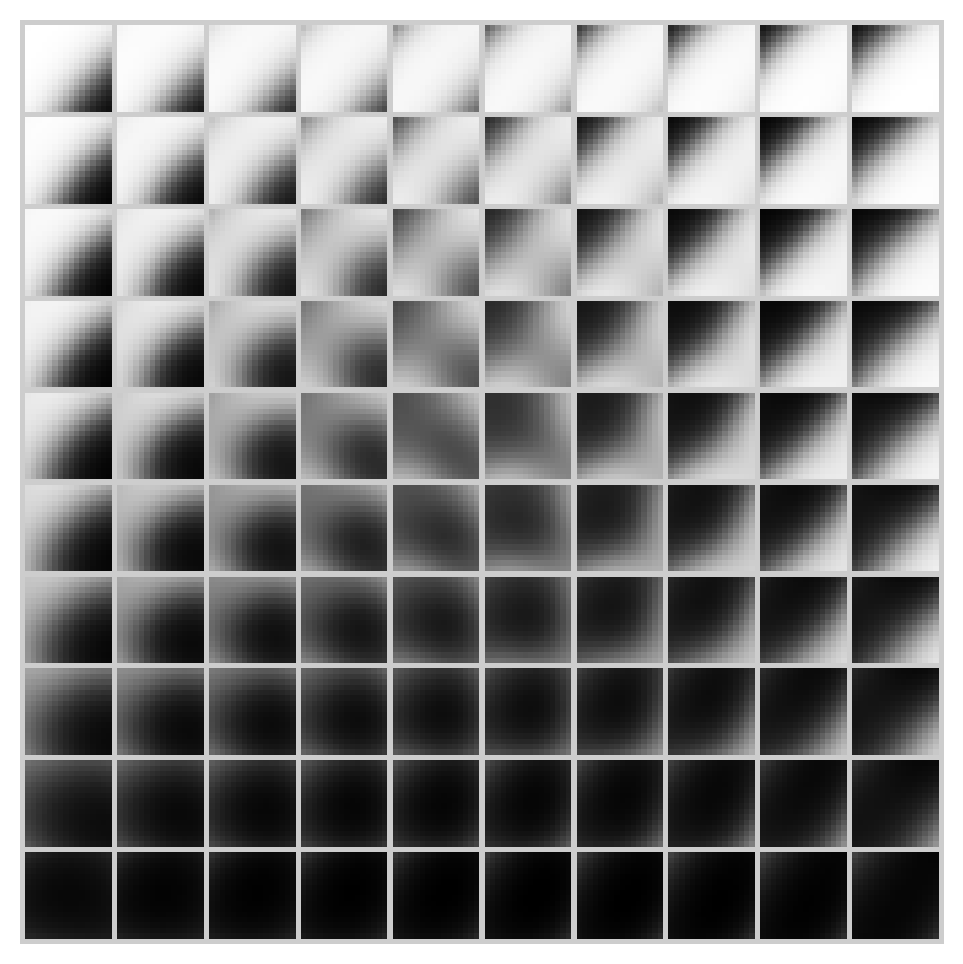

In [ ]:
grid = torchvision.utils.make_grid(manifold1, nrow=d, padding=1, pad_value=0.8)[0]
plt.figure(figsize=(6,6), dpi=200)
plt.imshow(grid, cmap='gray')
plt.axis("off")

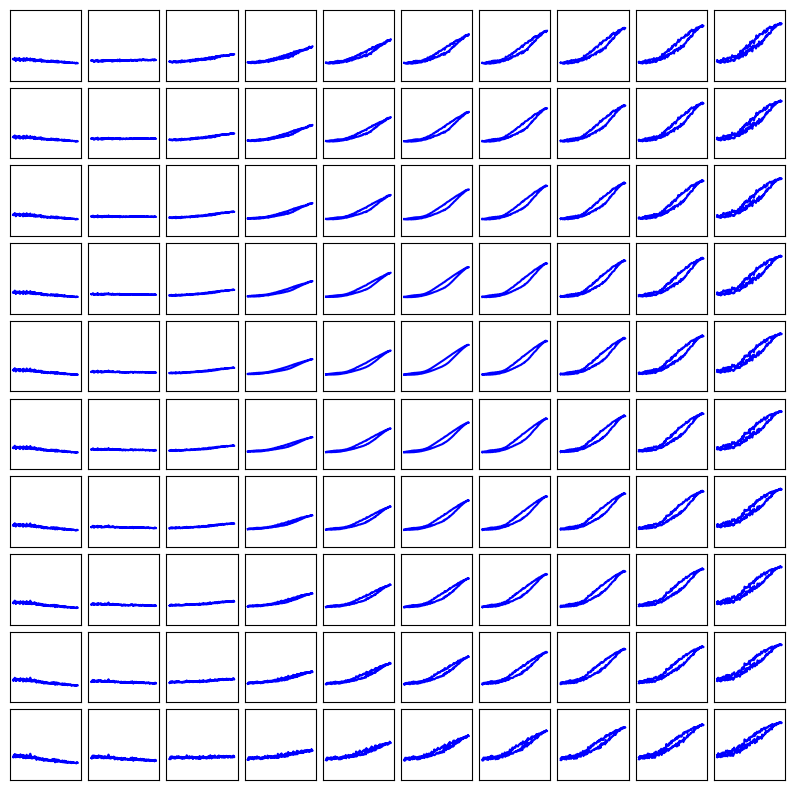

In [ ]:
_, axes = plt.subplots(d, d, figsize=(10, 10),dpi = 100,
                       subplot_kw={'xticks': [], 'yticks': []},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax, y in zip(axes.flat, manifold2):
    ax.plot(vdc, y.squeeze(), c = 'blue')
    ax.set_ylim(-0.3, 1.2)